In [520]:
from scipy.io import savemat, loadmat
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from pprint import pprint
import cv2

In [521]:
room_types = loadmat('./matlab/RoomLayoutTypes.mat')['type']

type_ = []
for idx in range(room_types.shape[1]):
    room_type_entry = room_types[0, idx]
    typeid = int(room_type_entry[0].squeeze())
    region = room_type_entry[1].squeeze().tolist()
    cornermap = room_type_entry[2].squeeze()
    lines = room_type_entry[3].squeeze()

    type_entry = {
        'typeid': typeid,
        'region': region,
        'cornermap': cornermap,
        'lines': lines
    }
    type_.append(type_entry)

pprint(type_)

[{'cornermap': array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8),
  'lines': array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8],
       [1, 3],
       [3, 5],
       [5, 7],
       [7, 1]], dtype=uint8),
  'region': [array([[4, 3, 5, 6]], dtype=uint8),
             array([[3, 1, 7, 5]], dtype=uint8),
             array([[6, 5, 7, 8]], dtype=uint8),
             array([[2, 1, 3, 4]], dtype=uint8),
             array([[8, 7, 1, 2]], dtype=uint8)],
  'typeid': 0},
 {'cornermap': array([3, 1, 4, 5, 7, 6], dtype=uint8),
  'lines': array([[1, 2],
       [1, 3],
       [1, 4],
       [4, 5],
       [4, 6]], dtype=uint8),
  'region': [array([[3, 1, 4, 6]], dtype=uint8),
             array([[5, 4, 1, 2]], dtype=uint8),
             array([[6, 4, 5]], dtype=uint8),
             array([[2, 1, 3]], dtype=uint8),
             array([], shape=(0, 0), dtype=uint8)],
  'typeid': 1},
 {'cornermap': array([1, 2, 3, 7, 8, 5], dtype=uint8),
  'lines': array([[1, 2],
       [1, 3],
       [1, 4],
      

In [522]:
i = 102 # 0
im_h = 512
im_w = 512

# This appears to be the original image size.
# For now, make it equal to im_h, im_w
im_res = np.array([im_w, im_h])

results_dir = '/home/richard/Development/pytorch-layoutnet-perspective/res/lsun_val'

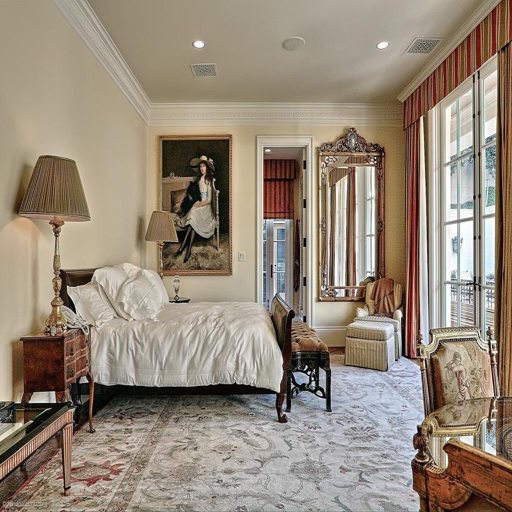

In [523]:
# im = Image.open(f'./result/res_lsun_ts_512_joint/img/{i}.png')
im = Image.open(os.path.join(results_dir, 'img', f'{i}.png'))
im

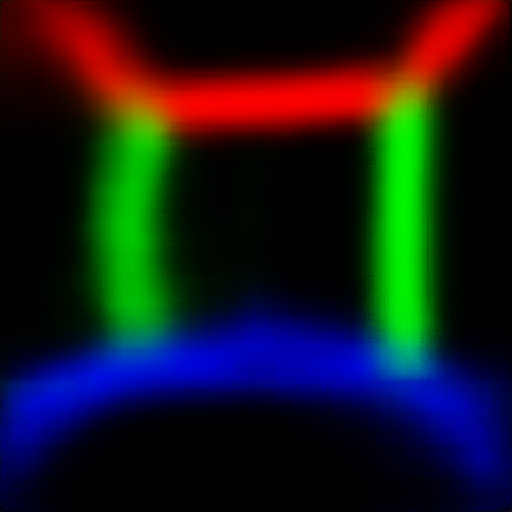

In [524]:
# edg = Image.open(f'./result/res_lsun_ts_512_joint/edg/{i}.png')
edg = Image.open(os.path.join(results_dir, 'edg', f'{i}.png'))
edg

In [525]:
edg = np.array(edg)
edg.shape

(512, 512, 3)

In [526]:
# corn = loadmat(f'./result/res_lsun_ts_512_joint/cor_mat/{i}.mat')['x']
corn = loadmat(os.path.join(results_dir, 'cor_mat', f'{i}.mat'))['x']
corn = corn.transpose(1, 2, 0) # CHW -> HWC
corn.shape

(512, 512, 8)

In [527]:
# corn_f = loadmat(f'./result/res_lsun_ts_512_joint/cor_mat_flip/{i}.mat')['x']
corn_f = loadmat(os.path.join(results_dir, 'cor_mat_flip', f'{i}.mat'))['x']
corn_f = corn_f.transpose(1, 2, 0)
corn_f.shape

(512, 512, 8)

In [528]:
# r_t = loadmat(f'./result/res_lsun_ts_512_joint/type/{i}.mat')['x']
r_t = loadmat(os.path.join(results_dir, 'type', f'{i}.mat'))['x']
r_t = r_t.mean(axis=0)
RecordId = r_t.argmax()

pprint(r_t)
pprint(RecordId)

array([9.8553813e-01, 8.9454741e-05, 8.5610722e-05, 2.0134820e-04,
       9.9606026e-05, 1.2796532e-02, 8.3653512e-04, 8.5610722e-05,
       8.5610722e-05, 8.5610722e-05, 9.6020573e-05], dtype=float32)
0


In [529]:
room_t = type_[RecordId]
pprint(room_t)

{'cornermap': array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8),
 'lines': array([[1, 2],
       [3, 4],
       [5, 6],
       [7, 8],
       [1, 3],
       [3, 5],
       [5, 7],
       [7, 1]], dtype=uint8),
 'region': [array([[4, 3, 5, 6]], dtype=uint8),
            array([[3, 1, 7, 5]], dtype=uint8),
            array([[6, 5, 7, 8]], dtype=uint8),
            array([[2, 1, 3, 4]], dtype=uint8),
            array([[8, 7, 1, 2]], dtype=uint8)],
 'typeid': 0}


In [530]:
# Skipped other room type for now

# TODO: could these computations be implemented in PyTorch model and exported (using compilation for conditionals, rather than tracing)?

if room_t['typeid'] == 0:
    corn_t = corn_f[:, :, 0].copy()
    corn_f[:, :, 0] = corn_f[:, :, 6]
    corn_f[:, :, 6] = corn_t

    corn_t = corn_f[:, :, 2].copy()
    corn_f[:, :, 2] = corn_f[:, :, 4]
    corn_f[:, :, 4] = corn_t

    corn_t = corn_f[:, :, 1].copy()
    corn_f[:, :, 1] = corn_f[:, :, 7]
    corn_f[:, :, 7] = corn_t

    corn_t = corn_f[:, :, 3].copy()
    corn_f[:, :, 3] = corn_f[:, :, 5]
    corn_f[:, :, 5] = corn_t

    corn[:, :, 2] = np.maximum(0, corn[:, :, 2] - corn[:, :, 3])
    corn[:, :, 4] = np.maximum(0, corn[:, :, 4] - corn[:, :, 5])
    corn[:, :, 0] = np.maximum(0, corn[:, :, 0] - corn[:, :, 1])
    corn[:, :, 6] = np.maximum(0, corn[:, :, 6] - corn[:, :, 7])

    corn_f[:, :, 2] = np.maximum(0, corn_f[:, :, 2] - corn_f[:, :, 3])
    corn_f[:, :, 4] = np.maximum(0, corn_f[:, :, 4] - corn_f[:, :, 5])
    corn_f[:, :, 0] = np.maximum(0, corn_f[:, :, 0] - corn_f[:, :, 1])
    corn_f[:, :, 6] = np.maximum(0, corn_f[:, :, 6] - corn_f[:, :, 7])

    corn[:, 399, 0] = 0
    corn[:, 399:, 2] = 0
    corn[:, 0:112, 6] = 0

    a = corn[:, :, 4].copy()
    b = corn[:, :, 2].copy()
    corn[:, :, 4] = np.maximum(corn[:, :, 4] - b, 0)
    corn[:, :, 2] = np.maximum(corn[:, :, 2] - a, 0)

    a = corn_f[:, :, 0].copy()
    b = corn_f[:, :, 6].copy()
    corn_f[:, :, 0] = np.maximum(corn_f[:, :, 0] - b, 0)
    corn_f[:, :, 6] = np.maximum(corn_f[:, :, 6] - a, 0)

    a = corn_f[:, :, 4].copy()
    b = corn_f[:, :, 2].copy()
    corn_f[:, :, 4] = np.maximum(corn_f[:, :, 4] - b, 0)
    corn_f[:, :, 2] = np.maximum(corn_f[:, :, 2] - a, 0)

    a = corn_f[:, :, 0].copy()
    b = corn_f[:, :, 6].copy()
    corn_f[:, :, 0] = np.maximum(corn_f[:, :, 0] - b, 0)
    corn_f[:, :, 6] = np.maximum(corn_f[:, :, 6] - a, 0)
    
elif room_t['typeid'] == 4:
    # TODO: probably could also be done by some swap function?
    corn_t = corn_f[:, :, 2].copy() # Mind that indexing in Matlab starts from 1, not 0
    corn_f[:, :, 2] = corn_f[:, :, 5]
    corn_f[:, :, 5] = corn_t

    corn[:, :, 4] = np.maximum(0, corn[:, :, 4] - corn[:, :, 2])
    corn_f[:, :, 4] = np.maximum(0, corn_f[:, :, 4] - corn_f[:, :, 2])

    corn[:, :, 4] = np.maximum(0, corn[:, :, 4] - corn[:, :, 5])
    corn_f[:, :, 4] = np.maximum(0, corn_f[:, :, 4] - corn_f[:, :, 5])

    corn[:, :, 6] = np.maximum(0, corn[:, :, 6] - corn[:, :, 0])
    corn_f[:, :, 6] = np.maximum(0, corn_f[:, :, 6] - corn_f[:, :, 0])
elif room_t['typeid'] == 5:
    corn_t = corn_f[:, :, 0].copy()
    corn_f[:, :, 0] = corn_f[:, :, 7]
    corn_f[:, :, 7] = corn_t

    corn_t = corn_f[:, :, 2].copy()
    corn_f[:, :, 2] = corn_f[:, :, 5]
    corn_f[:, :, 5] = corn_t

    corn[:, :, 6] = np.maximum(0, corn[:, :, 6] - corn[:, :, 0])
    corn_f[:, :, 6] = np.maximum(0, corn_f[:, :, 6] - corn_f[:, :, 0])
    
    corn[:, :, 4] = np.maximum(0, corn[:, :, 4] - corn[:, :, 2])
    corn_f[:, :, 4] = np.maximum(0, corn_f[:, :, 4] - corn_f[:, :, 2])

    corn[:, :, 6] = np.maximum(0, corn[:, :, 6] - corn[:, :, 7])
    corn_f[:, :, 6] = np.maximum(0, corn_f[:, :, 6] - corn_f[:, :, 7])

    corn[:, :, 4] = np.maximum(0, corn[:, :, 4] - corn[:, :, 5])
    corn_f[:, :, 4] = np.maximum(0, corn_f[:, :, 4] - corn_f[:, :, 5])
elif room_t['typeid'] == 6:
    corn_t = corn_f[:, :, 0].copy()
    corn_f[:, :, 0] = corn_f[:, :, 6]
    corn_f[:, :, 6] = corn_t

    corn_t = corn_f[:, :, 2].copy()
    corn_f[:, :, 2] = corn_f[:, :, 4]
    corn_f[:, :, 4] = corn_t
else:
    # TODO
    raise Exception(f'Unsupported room type {room_t["typeid"]} (yet)')

    ...

In [531]:
# Find corner
point = []
for j in range(len(room_t['cornermap'])):
    corn_idx = room_t['cornermap'][j] - 1
    mp = corn[:, :, corn_idx] + np.fliplr(corn_f[:, :, corn_idx])
    mp[:, 0] = 0
    mp[:, im_w - 1] = 0
    mp[0, :] = 0
    mp[im_h - 1, :] = 0

    # plt.figure()
    # plt.imshow(mp)

    mp_mat = loadmat(f'./matlab/mp{j+1}.mat')
    mp2 = mp_mat['mp']
    mp_msk2 = mp_mat['mp_msk']

    mp_msk = np.zeros_like(mp, dtype=np.float32)

    # TODO: handle other room types

    if room_t['typeid'] == 4:
        if room_t['cornermap'][j] == 5:
            mp_msk = edg[:, :, 1] > 255 * 0.1
        elif room_t['cornermap'][j] == 7:
            mp_msk = edg[:, :, 1] > 255 * 0.1
            mp_t = ((corn[:, :, 4] + np.fliplr(corn_f[:, :, 4])) / 2.0).copy()

            mp_t[:, 0] = 0
            mp_t[:, im_w - 1] = 0
            mp_t[0, :] = 0
            mp_t[im_h - 1, :] = 0
            mp_t = mp_t * mp_msk

            flat = np.ravel(mp_t, order='F')

            pt = np.argmax(flat)
            pt_x, _ = np.unravel_index(pt, mp_t.shape)

            mp_msk[:, :(max(pt_x - 50, 1)+1)] = 0
            mp_msk[:, min(pt_x + 50, im_w-1):] = 0
        elif room_t['cornermap'][j] == 3 or room_t['cornermap'][j] == 6:
            mp_msk = edg[:, :, 2] > 255 * 0.1

    elif room_t['typeid'] == 5:
        if room_t['cornermap'][j] == 7:
            mp_msk = edg[:, :, 1] > 255 * 0.1
        elif room_t['cornermap'][j] == 5:
            mp_msk = edg[:, :, 1] > 255 * 0.1
            
            mp_t = ((corn[:, :, 6] + np.fliplr(corn_f[:, :, 6])) / 2.0).copy()
            mp_t[:, 0] = 0
            mp_t[:, im_w - 1] = 0
            mp_t[0, :] = 0
            mp_t[im_h - 1, :] = 0
            mp_t = mp_t * mp_msk

            flat = np.ravel(mp_t, order='F')

            pt = np.argmax(flat)
            pt_x, _ = np.unravel_index(pt, mp_t.shape)

            mp_msk[:, :(max(pt_x - 50, 1)+1)] = 0
            mp_msk[:, min(pt_x + 50, im_w-1):] = 0
        elif room_t['cornermap'][j] == 1 or room_t['cornermap'][j] == 8:
            mp_msk = edg[:, :, 0] > 255 * 0.1
        elif room_t['cornermap'][j] == 3 or room_t['cornermap'][j] == 6:
            mp_msk = edg[:, :, 2] > 255 * 0.1
    
    elif room_t['typeid'] == 6:
        if room_t['cornermap'][j] == 1 or room_t['cornermap'][j] == 7:
            mp_msk = edg[:, :, 0] > 255 * 0.1
        elif room_t['cornermap'][j] == 3 or room_t['cornermap'][j] == 5:
            mp_msk = edg[:, :, 2] > 255 * 0.1

    elif room_t['typeid'] == 0:
        if room_t['cornermap'][j] == 5 or room_t['cornermap'][j] == 3:
            mp_msk = edg[:, :, 1] > 255 * 0.1
        elif room_t['cornermap'][j] == 1:
            mp_msk = edg[:, :, 1] > 255 * 0.1
            
            mp_t = ((corn[:, :, 2] + np.fliplr(corn_f[:, :, 2])) / 2.0).copy()
            mp_t[:, 0] = 0;
            mp_t[:, im_w - 1] = 0
            mp_t[0, :] = 0
            mp_t[im_h - 1, :] = 0
            mp_t = mp_t * mp_msk

            flat = np.ravel(mp_t, order='F')

            pt = np.argmax(flat)
            pt_x, _ = np.unravel_index(pt, mp_t.shape)

            mp_msk[:, :(max(pt_x - 50, 1)+1)] = 0
            mp_msk[:, min(pt_x + 50, im_w-1):] = 0
        elif room_t['cornermap'][j] == 7:
            mp_msk = edg[:, :, 1] > 255 * 0.1

            mp_t = ((corn[:, :, 4] + np.fliplr(corn_f[:, :, 4])) / 2.0).copy()
            mp_t[:, 0] = 0;
            mp_t[:, im_w - 1] = 0
            mp_t[0, :] = 0
            mp_t[im_h - 1, :] = 0
            mp_t = mp_t * mp_msk

            flat = np.ravel(mp_t, order='F')

            pt = np.argmax(flat)
            pt_x, _ = np.unravel_index(pt, mp_t.shape)

            mp_msk[:, :(max(pt_x - 50, 1)+1)] = 0
            mp_msk[:, min(pt_x + 50, im_w-1):] = 0 
        elif room_t['cornermap'][j] == 8 or room_t['cornermap'][j] == 2:
            mp_msk = edg[:, :, 0] > 255 * 0.1
        elif room_t['cornermap'][j] == 4 or room_t['cornermap'][j] == 6:
            mp_msk = edg[:, :, 2] > 255 * 0.1

    else:
        raise Exception(f'Room type {room_t["typeid"]} not supported yet!')

    mp = mp * mp_msk

    # Different order than in Matlab because Matlab arrays are column-first, whereas in numpy arrays are row-first
    # Although indexing starts with row, as in numpy
    pt = np.argmax(np.ravel(mp, order='F') / 2)
    pt_y, pt_x = np.unravel_index(pt, mp.shape)

    point.append([pt_x, pt_y])

point = np.array(point)
pprint(point)

array([[102, 146],
       [  3,  43],
       [346, 143],
       [442,   6],
       [346, 401],
       [467, 507],
       [ 86, 397],
       [  2, 491]])


In [532]:
room_t

{'typeid': 0,
 'region': [array([[4, 3, 5, 6]], dtype=uint8),
  array([[3, 1, 7, 5]], dtype=uint8),
  array([[6, 5, 7, 8]], dtype=uint8),
  array([[2, 1, 3, 4]], dtype=uint8),
  array([[8, 7, 1, 2]], dtype=uint8)],
 'cornermap': array([1, 2, 3, 4, 5, 6, 7, 8], dtype=uint8),
 'lines': array([[1, 2],
        [3, 4],
        [5, 6],
        [7, 8],
        [1, 3],
        [3, 5],
        [5, 7],
        [7, 1]], dtype=uint8)}

In [533]:
point_res = np.array([
    point[:, 1],
    point[:, 0]
]).T # Transpose to match Matlab output

point_res

array([[146, 102],
       [ 43,   3],
       [143, 346],
       [  6, 442],
       [401, 346],
       [507, 467],
       [397,  86],
       [491,   2]])

In [534]:
cor_res = im_res / np.array([im_w, im_h])

cor_res

array([1., 1.])

In [535]:
point_ref_res = (point_res * cor_res)

# [[y, x]]
point_ref_res

array([[146., 102.],
       [ 43.,   3.],
       [143., 346.],
       [  6., 442.],
       [401., 346.],
       [507., 467.],
       [397.,  86.],
       [491.,   2.]])

In [536]:
point_ref_res[point_ref_res[:, 0] > im_res[1], 0] = im_res[1] # Exceeds height
point_ref_res[point_ref_res[:, 1] > im_res[0], 0] = im_res[0] # Exceeds width
point_ref_res[point_ref_res < 0] = 0
point_ref_res

array([[146., 102.],
       [ 43.,   3.],
       [143., 346.],
       [  6., 442.],
       [401., 346.],
       [507., 467.],
       [397.,  86.],
       [491.,   2.]])

In [537]:
# Refine point
point = point_ref_res
point_ref = point.copy()

point

array([[146., 102.],
       [ 43.,   3.],
       [143., 346.],
       [  6., 442.],
       [401., 346.],
       [507., 467.],
       [397.,  86.],
       [491.,   2.]])

In [538]:
# [0 0; 0 im_res(1)+0.01; im_res(2)+0.01 im_res(1)+0.01; im_res(2)+0.01 0]
P = np.array([
    [0 ,0],
    [0, im_res[0] + 0.01],
    [im_res[1] + 0.01, im_res[0] + 0.01],
    [im_res[1] + 0.01, 0]
])
P = P.T

P

array([[  0.  ,   0.  , 512.01, 512.01],
       [  0.  , 512.01, 512.01,   0.  ]])

In [539]:
P = np.hstack((P, P[:, 0][:, None]))

P

array([[  0.  ,   0.  , 512.01, 512.01,   0.  ],
       [  0.  , 512.01, 512.01,   0.  ,   0.  ]])

In [540]:
def seg2poly(s1, P):
    '''
    Check if a line segment s intersects with a polygon P.

    Parameteres:
        s: (2 x 2) array where
            s[:, 0] is the first point
            s[:, 1] is the second point of the segment
        P is (2 x n) array, each column is a vertice
    
    Returns:
        A (2 x m) array, each column is an intersecting point

    '''
    ...

    a = np.expand_dims(s1[:, 0], axis=1)
    M = P - a

    b = (np.expand_dims(s1[:, 1], axis=1) - a)
    b = np.array([b[0, 0], b[1, 0]])

    # In the original code it is [b(2) - b(1)] * M
    x = np.array([b[1], -b[0]]).dot(M)

    sx = np.sign(x)
    
    ind = (sx[0:-1] * sx[1:]) <= 0

    if np.any(ind):
        ind = np.where(ind)
        # Cross point to the y-axis (along the segment)
        x1 = x[ind]
        x2 = x[ind + np.array([1])][0]

        d = b / (b[0] ** 2 + b[1] ** 2)

        y1 = d.dot(M[:, ind].squeeze())
        y2 = d.dot(M[:, ind + np.array([1])].squeeze())

        dx = x2 - x1

        # We won't bother with the degenerate case of dx=0 and x1=0
        y = (y1 * x2 - y2 * x1) / dx
        
        # Check if the cross point is inside the segment
        ind = np.logical_and(y >= 0, y < 1)
        if np.any(ind):
            # print('aaa')
            X = a.squeeze() + b * y[np.where(ind)]
        else:
            # print('bbb')
            X = np.zeros((2,))
    else:
        # print('ccc')
        X = np.zeros((2,))
    
    # print('\t returning', X)
    return X

t_s1 = np.array([
    [157.0, -100.0],
    [331.0, 530.8889]
])
t_P = np.array([
    [0.0, 0.0, 512.01, 512.01, 0.0],
    [0.0, 512.01, 512.01, 0.0 ,0.0]
])

assert np.allclose(seg2poly(t_s1, t_P), np.array([0.0, 453.1111]))

In [541]:
# Refine point
if room_t['typeid'] == 0:
    line_1 = np.polyfit(
        [point[0, 0], point[1, 0]],
        [point[0, 1], point[1, 1]],
        1
    )
    print('line_1', line_1)
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    print("s1", s1)
    X = seg2poly(s1, P)
    print('X1', X)
    point_ref[1, :] = X.T

    line_1 = np.polyfit(
        [point[2, 0], point[3, 0]],
        [point[2, 1], point[3, 1]],
        1
    )
    print('line_1', line_1)
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[2, 0], point[2, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    print("s1", s1)
    X = seg2poly(s1, P)
    print('X2', X)
    point_ref[3, :] = X.T

    line_1 = np.polyfit(
        [point[4, 0], point[5, 0]],
        [point[4, 1], point[5, 1]],
        1
    )
    print('line_1', line_1)
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[4, 0], point[4, 1]]
    s1[:, 1] = [100000, 100000 * line_1[0] + line_1[1]]
    print("s1", s1)
    X = seg2poly(s1, P)
    print('X3', X)
    point_ref[5, :] = X.T

    line_1 = np.polyfit(
        [point[6, 0], point[7, 0]],
        [point[6, 1], point[7, 1]],
        1
    )
    print('line_1', line_1)
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[6, 0], point[6, 1]]
    s1[:, 1] = [100000, 100000 * line_1[0] + line_1[1]]
    print("s1", s1)
    X = seg2poly(s1, P)
    print('X4', X)
    point_ref[7, :] = X.T
   

elif room_t['typeid'] == 4:
    # Find a polynomial of degree 1 that passes through points indicated by these x and y arrays
    # Effectivaly, this is a line
    line_1 = np.polyfit(
        [point[0, 0], point[1, 0]],
        [point[0, 1], point[1, 1]],
        1
    )

    viz = True
    if viz:
        xn = np.linspace(0, 512, 100)
        yn = np.poly1d(line_1)
        plt.plot(xn, yn(xn), [point[0, 0], point[1, 0]],
                 [point[0, 1], point[1, 1]], 'o')
        plt.title(f'Polynomial passing through {point[0]} and {point[1]}')
        plt.grid()

    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]

    X = seg2poly(s1, P)

    point_ref[1, :] = X.T

    if point[0, 0] == point[2, 0]:
        point[0, 0] = point[0, 0] + 0.01

    line_1 = np.polyfit(
        [point[0, 0], point[2, 0]],
        [point[0, 1], point[2, 1]],
        1
    )

    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [-1 - line_1[1] / line_1[0], -1]
    X = seg2poly(s1, P)
    point_ref[2, :] = X.T  # Transpose is not actually necessary in numpy here

    line_1 = np.polyfit(
        [point[0, 0], point[3, 0]],
        [point[0, 1], point[3, 1]],
        1
    )
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [10000, 10000 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)

    point_ref[3, :] = X.T  # Transpose is not actually necessary in numpy here
elif room_t['typeid'] == 5:
    line_1 = np.polyfit(
        [point[0, 0], point[1, 0]],
        [point[0, 1], point[1, 1]],
        1
    )
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[1, :] = X.T

    line_1 = np.polyfit(
        [point[0, 0], point[2, 0]],
        [point[0, 1], point[2, 1]],
        1
    )
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [10000, 10000 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[2, :] = X.T

    line_1 = np.polyfit(
        [point[3, 0], point[4, 0]],
        [point[3, 1], point[4, 1]],
        1
    )
    s1[:, 0] = [point[3, 0], point[3, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[4, :] = X.T

    line_1 = np.polyfit(
        [point[3, 0], point[5, 0]],
        [point[3, 1], point[5, 1]],
        1
    )
    s1[:, 0] = [point[3, 0], point[3, 1]]
    s1[:, 1] = [10000, 10000 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[5, :] = X.T

elif room_t['typeid'] == 6:
    line_1 = np.polyfit(
        [point[0, 0], point[1, 0]],
        [point[0, 1], point[1, 1]],
        1
    )
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[0, 0], point[0, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[0, :] = X.T
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[1, 0], point[1, 1]]
    s1[:, 1] = [10000, 10000 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[1, :] = X.T

    line_1 = np.polyfit(
        [point[2, 0], point[3, 0]],
        [point[2, 1], point[3, 1]],
        1
    )
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[2, 0], point[2, 1]]
    s1[:, 1] = [-100, -100 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[2, :] = X.T
    s1 = np.zeros((2, 2))
    s1[:, 0] = [point[3, 0], point[3, 1]]
    s1[:, 1] = [10000, 1000 * line_1[0] + line_1[1]]
    X = seg2poly(s1, P)
    point_ref[3, :] = X.T
else:
    raise Exception(f'Room type {room_t["typeid"]} not supported yet')



line_1 [  0.96116505 -38.33009709]
s1 [[ 146.         -100.        ]
 [ 102.         -134.44660194]]
X1 [3.98787879e+01 1.42108547e-14]
line_1 [ -0.70072993 446.20437956]
s1 [[ 143.         -100.        ]
 [ 346.          516.27737226]]
X2 [  0.         446.20437956]
line_1 [   1.14150943 -111.74528302]
s1 [[   401.         100000.        ]
 [   346.         114039.19811321]]
X3 [512.01       472.71896226]
line_1 [ -0.89361702 440.76595745]
s1 [[ 3.97000000e+02  1.00000000e+05]
 [ 8.60000000e+01 -8.89209362e+04]]
X4 [4.93238095e+02 1.42108547e-14]


In [542]:
data = {}
data['type'] = room_t['typeid']
data['point'] = point_ref
data['resolution'] = im_res

data

{'type': 0,
 'point': array([[1.46000000e+02, 1.02000000e+02],
        [3.98787879e+01, 1.42108547e-14],
        [1.43000000e+02, 3.46000000e+02],
        [0.00000000e+00, 4.46204380e+02],
        [4.01000000e+02, 3.46000000e+02],
        [5.12010000e+02, 4.72718962e+02],
        [3.97000000e+02, 8.60000000e+01],
        [4.93238095e+02, 1.42108547e-14]]),
 'resolution': array([512, 512])}

In [543]:
import numpy as np
import cv2
from scipy.ndimage import label, binary_erosion

def getSegmentation(data):
    # GETSEGMENTATION CONVERT ROOM LAYOUT TO SEGMENTATION MASK
    #   data.type: room layout type
    #   data.point: room corners position
    #   data.resolution: [w h] of the image
    
    if data['type'] == 11:
        segment = None
        return segment

    # TODO: convert `type_` to be dict where key is typeid
    type_data = type_[data['type']]

    point = data['point']
    # lines describes the layout line ordering in this room type
    lines = type_data['lines']
    
    # Convert 'point' to integer type
    point = point.astype(int)

    # Select first point using room lines info
    pt1s = point[lines[:, 0] - 1]
    pt1s[pt1s <= 0] = 1
    pt1s[pt1s[:, 0] > data['resolution'][0], 0] = data['resolution'][0]
    pt1s[pt1s[:, 1] > data['resolution'][1], 1] = data['resolution'][1]
    
    pt2s = point[lines[:, 1] - 1]
    pt2s[pt2s <= 0] = 1
    pt2s[pt2s[:, 0] > data['resolution'][0], 0] = data['resolution'][0]
    pt2s[pt2s[:, 1] > data['resolution'][1], 1] = data['resolution'][1]
    
    lineplot = np.zeros(data['resolution'], dtype=np.uint8)
    line_coords = []
    for pt1, pt2 in zip(pt1s, pt2s):
        pt1 = tuple(pt1)
        pt2 = tuple(pt2)
        lineplot = cv2.line(lineplot, pt1, pt2, 1, 1)
        line_coords.append((pt1, pt2))
    
    labeled_array, num_features = label(1 - lineplot)
    
    segment = np.zeros(data['resolution'], dtype=int)
    for i in range(1, num_features + 1):
        segment[labeled_array == i] = i
    
    se = np.ones((2, 2), dtype=bool)  # Equivalent to strel('disk', 2) in MATLAB
    # Make lines wider for better visalization
    segment = binary_erosion(segment, structure=se)
    
    return segment, line_coords


segm, lines = getSegmentation(data)
segm.shape, lines

((512, 512),
 [((146, 102), (39, 1)),
  ((143, 346), (1, 446)),
  ((401, 346), (512, 472)),
  ((397, 86), (493, 1)),
  ((146, 102), (143, 346)),
  ((143, 346), (401, 346)),
  ((401, 346), (397, 86)),
  ((397, 86), (146, 102))])

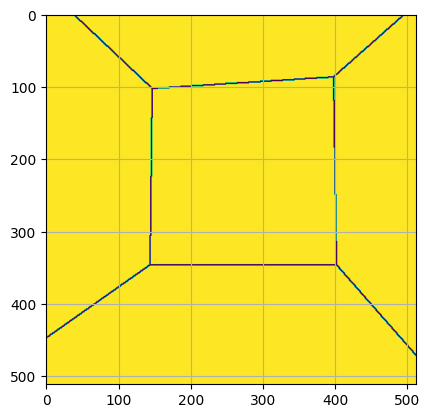

In [544]:
plt.imshow(segm)
plt.grid();

In [545]:
data

{'type': 0,
 'point': array([[1.46000000e+02, 1.02000000e+02],
        [3.98787879e+01, 1.42108547e-14],
        [1.43000000e+02, 3.46000000e+02],
        [0.00000000e+00, 4.46204380e+02],
        [4.01000000e+02, 3.46000000e+02],
        [5.12010000e+02, 4.72718962e+02],
        [3.97000000e+02, 8.60000000e+01],
        [4.93238095e+02, 1.42108547e-14]]),
 'resolution': array([512, 512])}

(146, 102) (39, 1)
(143, 346) (1, 446)
(401, 346) (512, 472)
(397, 86) (493, 1)
(146, 102) (143, 346)
(143, 346) (401, 346)
(401, 346) (397, 86)
(397, 86) (146, 102)


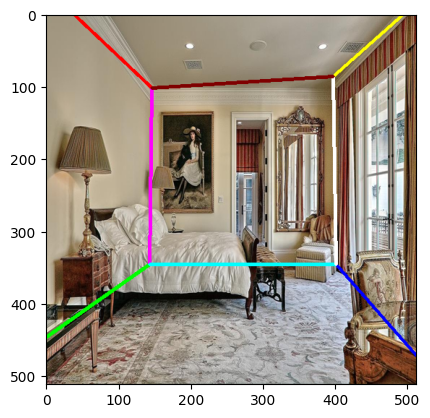

In [550]:
image = np.array(im).copy()
colors = [
    (255, 0 ,0 ),
    (0, 255 ,0 ),
    (0, 0 ,255 ),
    (255, 255 ,0 ),
    (255, 0 ,255 ),
    (0, 255 ,255 ),
    (255, 255 ,255 ),
    (127, 0, 0)
]
for (p1, p2), color in zip(lines, colors):
    print(p1, p2)

    image = cv2.line(image, p1, p2, color, 3)

plt.imshow(image);

In [547]:
import mat73

mat_ts = mat73.loadmat('./result/res_lsun_ts_512_joint/mat_ts_v73/sun_agjyxmbsjvhuoaau.mat')
layout = mat_ts['result']['layout']
layout.shape

(512, 512)

In [548]:
! pwd

/home/richard/Development/LayoutNet


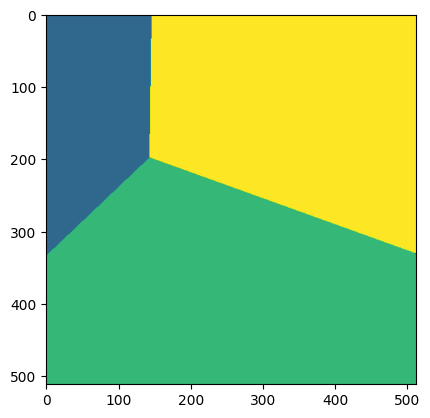

In [549]:
plt.imshow(layout);